# Class prior estimation methods

Cost-sensitive approaches crucially rely on the knowledge of outcome prior $\pi$, which might have a large impact on the quality of the recommendations. $y \in \{−1, 0, 1\}$ are the accessible labels. Let us denote $s \in \{−1, 1\}$ the true labels, and $v$ is the feature vector. Under the usual assumptions made in Positive-Unlabeled (PU) learning:
$$\pi := \mathbb{P}(s = 1 \mid y =0)\;.$$

**benchscofi** provides implementations of several class prior estimation methods, shown below. We will test their performance on a randomly generated subset, resp. on real-life drug repurposing datasets.

In [1]:
from importlib import reload
import stanscofi.datasets
import stanscofi.utils
import numpy as np

import sys
sys.path.insert(0,"src/")

import benchscofi
import benchscofi.utils
from benchscofi.utils import prior_estimation

rseed=12345

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-03 15:53:41.405159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 15:53:43.723392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Datasets

### 1.1 Randomly generated PU dataset, with exactly known true $\pi$

Function *stanscofi.datasets.generate_dummy_dataset* generates the following dataset. 

Each of the $N_f$ features for (item, user) pair feature vectors associated with positive ratings are drawn from a Gaussian distribution of mean $\text{mean}$ and standard deviation $\text{std}$, whereas those for negative ratings are drawn from from a Gaussian distribution of mean $m=-\text{mean}$ and standard deviation $\text{std}$. 

We generate for "drugs" and "diseases" two matrices of shape $(\lfloor N_f/2 \rfloor, N_\text{pos}+N_\text{neg})$, which are the concatenation of $N_\text{pos}$ positive and $N_\text{neg}$ negative pair feature vectors generated from Gaussian distributions. Thus there are $N_\text{pos}^2$ positive ratings (each "positive" disease with a "positive" drug), $N_\text{neg}^2$ negative ratings (*idem*), and the remainder is unknown (that is, $(N_\text{pos}+N_\text{neg})^2-N_\text{pos}^2-N_\text{neg}^2$ ratings).

In particular, here, for a fixed $\pi$ and $N$, $N_\text{pos}=\lfloor \sqrt{\pi} N\rfloor$ and $N_\text{neg}=N-N_\text{pos}$, such that 

$$\mathbb{P}(y=1) = p_+ = (\sqrt{\pi} N/N)^2 = \pi \text{ and }$$

True generated pi=0.3
Estimated pi=0.5 (#positive/#known)
Estimated pi=0.21 (#positive/#total)
Estimated pi=0.3620689655172414 (#positive/#unknown)
Estimated pi=0.3 from true labels (#positive/#unknown)


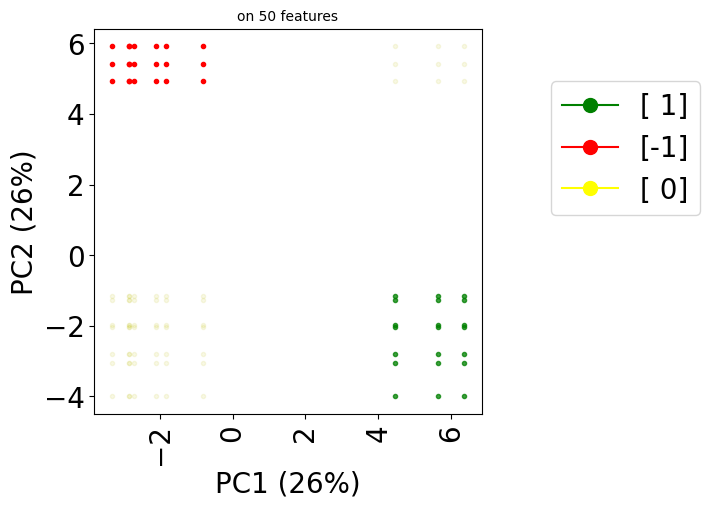

In [2]:
reload(benchscofi.utils.prior_estimation)

synthetic_params = {
    "N":10, "nfeatures":50, "pi": 0.3, "mean":1, "std":1, "exact": True, "random_state": rseed,
}
data_args, labels_mat = prior_estimation.generate_PU_dataset(**synthetic_params)

#npositive, nnegative = int(np.sqrt(true_pi)*N),N-int(np.sqrt(true_pi)*N)
#data_args = stanscofi.datasets.generate_dummy_dataset(npositive,nnegative,nfeatures,mean,std,random_state=rseed)

synthetic_dataset = stanscofi.datasets.Dataset(**data_args)

print("True generated pi="+str(synthetic_params["pi"]))

estimated_pi1=np.sum(synthetic_dataset.ratings[:,2]>0)/synthetic_dataset.ratings.shape[0]
estimated_pi2=np.sum(synthetic_dataset.ratings_mat>0)/np.prod(synthetic_dataset.ratings_mat.shape)
estimated_pi3=np.sum(synthetic_dataset.ratings_mat>0)/np.sum(synthetic_dataset.ratings_mat==0)

print("Estimated pi="+str(estimated_pi1)+" (#positive/#known)")
print("Estimated pi="+str(estimated_pi2)+" (#positive/#total)")
print("Estimated pi="+str(estimated_pi3)+" (#positive/#unknown)")

estimated_true_pi=np.sum(labels_mat.values==2)/np.sum(np.abs(labels_mat.values)==2)
print("Estimated pi="+str(estimated_true_pi)+" from true labels (#positive/#unknown)")

synthetic_dataset.visualize(withzeros=True)

### 1.2 Real-life drug repurposing dataset

Estimated pi=1.0 (#positive/#known)
Estimated pi=0.010414365682698577 (#positive/#total)
Estimated pi=0.010523966114244648 (#positive/#unknown)


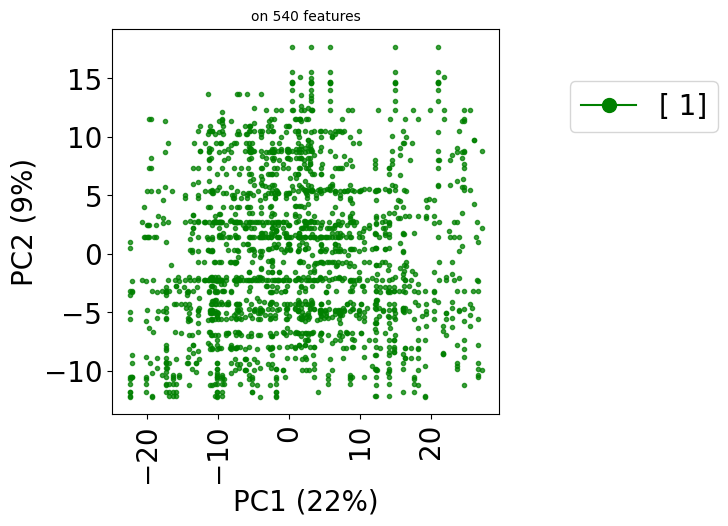

In [3]:
dataset_name="Gottlieb"

data_args = stanscofi.utils.load_dataset(dataset_name, "datasets/")
real_dataset = stanscofi.datasets.Dataset(**data_args)

estimated_pi1=np.sum(real_dataset.ratings[:,2]>0)/real_dataset.ratings.shape[0]
estimated_pi2=np.sum(real_dataset.ratings_mat>0)/np.prod(real_dataset.ratings_mat.shape)
estimated_pi3=np.sum(real_dataset.ratings_mat>0)/np.sum(real_dataset.ratings_mat==0)

print("Estimated pi="+str(estimated_pi1)+" (#positive/#known)")
print("Estimated pi="+str(estimated_pi2)+" (#positive/#total)")
print("Estimated pi="+str(estimated_pi3)+" (#positive/#unknown)")

real_dataset.visualize(withzeros=False)

## 2. Methods relying on a pretrained classifier

### 2.1 Train a classifier

<validation.compute_metrics> Computed on #users=10, 3 ignored (30 perc)


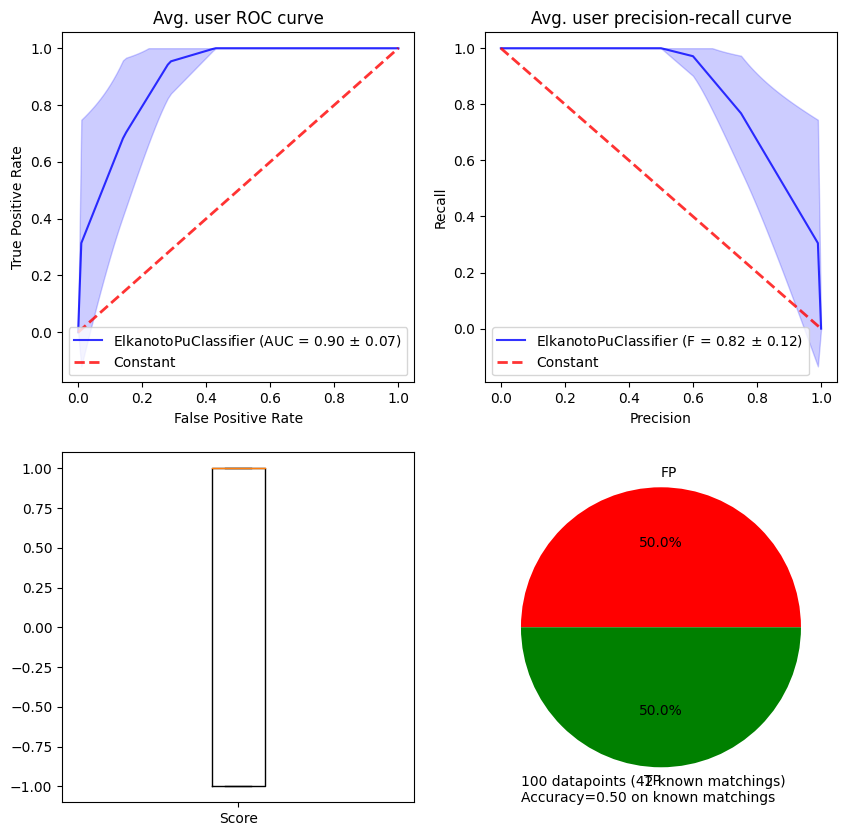

,Avg. across users,Std
AUC,0.897959,0.074984
F_1.0,0.824830,0.122023


In [4]:
import benchscofi.PulearnWrapper
from stanscofi.training_testing import traintest_validation_split
from stanscofi.validation import compute_metrics, plot_metrics
from sklearn.svm import SVC

## Model parameters
params = {
            "decision_threshold": 0., 
            "classifier_params": {
                "estimator": SVC(C=10., kernel='rbf', gamma=0.4, probability=True),
                "hold_out_ratio": 0.2,
                #"labeled":10, "unlabeled":20, "n_estimators":15,
            },
            "classifier": "ElkanotoPuClassifier",
            "preprocessing": "meanimputation_standardize",
            "subset": None,
            "random_state": rseed,
        }

model = benchscofi.PulearnWrapper.PulearnWrapper(params)
model.fit(synthetic_dataset)

## Predict the model on the testing dataset
scores = model.predict(synthetic_dataset)
predictions = model.classify(scores)

## Validate the model on the testing dataset
metrics, plot_args = compute_metrics(scores, predictions, synthetic_dataset, ignore_zeroes=False, verbose=True)
plot_metrics(**plot_args, figsize=(10,10), model_name=model.name)
metrics

In [12]:
## Supplementary validation dataset
synthetic_params_val = synthetic_params.copy()
synthetic_params_val.update({"random_state": rseed*2})
data_args_val, labels_mat_val = prior_estimation.generate_PU_dataset(**synthetic_params_val)
synthetic_dataset_val = stanscofi.datasets.Dataset(**data_args_val)

print("True generated pi="+str(synthetic_params_val["pi"]))

estimated_pi1=np.sum(synthetic_dataset.ratings[:,2]>0)/synthetic_dataset.ratings.shape[0]
estimated_pi2=np.sum(synthetic_dataset.ratings_mat>0)/np.prod(synthetic_dataset.ratings_mat.shape)
estimated_pi3=np.sum(synthetic_dataset.ratings_mat>0)/np.sum(synthetic_dataset.ratings_mat==0)

print("Estimated pi="+str(estimated_pi1)+" (#positive/#known)")
print("Estimated pi="+str(estimated_pi2)+" (#positive/#total)")
print("Estimated pi="+str(estimated_pi3)+" (#positive/#unknown)")

estimated_true_pi=np.sum(labels_mat_val.values==2)/np.sum(np.abs(labels_mat_val.values)==2)
print("Estimated pi="+str(estimated_true_pi)+" from true labels (#positive/#unknown)")

True generated pi=0.3
Estimated pi=0.5 (#positive/#known)
Estimated pi=0.21 (#positive/#total)
Estimated pi=0.3620689655172414 (#positive/#unknown)
Estimated pi=0.3 from true labels (#positive/#unknown)


### 2.2 First approaches

Three estimators $e_1$, $e_2$ and $e_3$ of $c := \mathbb{P}(s=1 \mid y \neq 0)$ proposed by **[1]**. Given a trained classifier $\widehat{\theta}$, and a validation set $\mathcal{V} := \{ (v,y) \mid y \in \{-1,0,1\}, v \in \mathbb{R}^d \}$,
$$ e_1 := \frac{1}{|\{v \mid (v,+1) \in \mathcal{V}\}|}\sum_{(v,+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;;  e_2 := \frac{\sum_{(v',+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v'))_+}{\sum_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+}\;; e_3 := \max_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;. $$

If $f_{\widehat{\theta}}(v)=\mathbb{P}(s=1 | v)$ for any $v$, then $e_1=c$. It is assumed that $e_3 \leq c$. Authors recommend using $e_1$. But that approach requires having access to a supplementary validation dataset with labelled samples.

**[1]** Charles Elkan and Keith Noto. Learning classifiers from only positive and unlabeled data. In Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining, pages 213–220, 2008.

In [31]:
from benchscofi.utils import prior_estimation
reload(prior_estimation)

<module 'benchscofi.utils.prior_estimation' from 'src/benchscofi/utils/prior_estimation.py'>

In [17]:
e1, e2, e3 = [
    prior_estimation.data_aided_estimation(model, synthetic_dataset_val, estimator_type=i) for i in [1,2,3]
             ]
e1, e2, e3

(1.0, 0.21, 1.0)

TODO ROC curve

In [18]:
pi_star = [prior_estimation.roc_aided_estimation(model, synthetic_dataset_val, ignore_zeroes=False, 
                                                regression_type=i) for i in [1,2]]
pi_star

src/benchscofi/utils/prior_estimation.py:84: RuntimeWarning: divide by zero encountered in log
  return -2*np.sum( np.multiply(mean_tprs, np.log(f(base_fprs))) + np.multiply(1-mean_tprs, np.log(1-f(base_fprs))) )
src/benchscofi/utils/prior_estimation.py:84: RuntimeWarning: invalid value encountered in multiply
  return -2*np.sum( np.multiply(mean_tprs, np.log(f(base_fprs))) + np.multiply(1-mean_tprs, np.log(1-f(base_fprs))) )
src/benchscofi/utils/prior_estimation.py:86: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(binomial_deviance, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
src/benchscofi/utils/prior_estimation.py:73: RuntimeWarning: divide by zero encountered in divide
  return lambda x : (1-gamma)*np.power(1+Delta*(1/np.power(alpha,mu)-1), -1/mu)+gamma*alpha
src/benchscofi/utils/prior_estimation.py:84: RuntimeWarning: divide by zero encountered in log
  return -2*np.sum( np.multiply(mean_tprs, np.log(f(base_fprs))) 

[1.0, 1.0]

TODO penalized divergences

In [32]:
pi_hat = [prior_estimation.divergence_aided_estimation(synthetic_dataset_val, "meanimputation_standardize", lmb=1., 
                                            sigma=1., divergence_type=div) for div in ["L1-distance","Pearson"]]
pi_hat 

ValueError: shapes (2,) and (21,) not aligned: 2 (dim 0) != 21 (dim 0)